In [1]:
#from tcn import TCN
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import math
from tqdm.notebook import tqdm
import random
import time as t
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")


2024-02-10 16:44:54.693008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 16:44:54.693107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 16:44:54.814127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
# Setting seeds value for results reproducability
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
# Assuming your DataFrame is named 'df' path: /kaggle/working/Solar-Irradiance-Forecasting/Solar Irradiance Dataset Karachi/2017.csv
desired_starting_row = 3

path2017 = "/kaggle/input/solar-irradiance-dataset-karachi/2017.csv"
path2018 = "/kaggle/input/solar-irradiance-dataset-karachi/2018.csv"
path2019 = "/kaggle/input/solar-irradiance-dataset-karachi/2019.csv"

df2017 = pd.read_csv(path2017, skiprows=desired_starting_row - 1)
df2018 = pd.read_csv(path2018, skiprows=desired_starting_row - 1)
df2019 = pd.read_csv(path2019, skiprows=desired_starting_row - 1)



In [5]:
# merging two csv files 
df = pd.concat([df2017 , df2018 , df2019], ignore_index=True) 

In [6]:
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [7]:
df.head(-10)

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,date
0,2017,1,1,0,0,17.6,0,0,0,0,...,0,0.241,72.52,120.12,0.17,1014,1.3,52,2.3,2017-01-01 00:00:00
1,2017,1,1,0,15,17.6,0,0,0,0,...,0,0.241,72.52,116.82,0.17,1014,1.3,53,2.3,2017-01-01 00:15:00
2,2017,1,1,0,30,17.5,0,0,0,0,...,0,0.241,72.98,113.53,0.17,1014,1.3,54,2.4,2017-01-01 00:30:00
3,2017,1,1,0,45,17.4,0,0,0,0,...,0,0.241,67.37,110.26,0.17,1014,1.3,56,2.5,2017-01-01 00:45:00
4,2017,1,1,1,0,17.3,0,0,0,0,...,0,0.241,67.86,107.02,0.17,1015,1.3,57,2.5,2017-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105105,2019,12,31,20,15,13.4,0,0,0,0,...,0,0.277,51.87,170.68,0.17,1017,0.9,65,3.7,2019-12-31 20:15:00
105106,2019,12,31,20,30,13.3,0,0,0,0,...,0,0.277,52.21,167.30,0.17,1017,0.9,65,3.7,2019-12-31 20:30:00
105107,2019,12,31,20,45,13.2,0,0,0,0,...,0,0.278,52.38,163.91,0.17,1017,0.9,64,3.8,2019-12-31 20:45:00
105108,2019,12,31,21,0,13.1,0,0,0,0,...,0,0.278,52.72,160.51,0.17,1017,0.9,63,3.9,2019-12-31 21:00:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Year                105120 non-null  int64         
 1   Month               105120 non-null  int64         
 2   Day                 105120 non-null  int64         
 3   Hour                105120 non-null  int64         
 4   Minute              105120 non-null  int64         
 5   Temperature         105120 non-null  float64       
 6   Clearsky DHI        105120 non-null  int64         
 7   Clearsky DNI        105120 non-null  int64         
 8   Clearsky GHI        105120 non-null  int64         
 9   Cloud Type          105120 non-null  int64         
 10  Dew Point           105120 non-null  float64       
 11  DHI                 105120 non-null  int64         
 12  DNI                 105120 non-null  int64         
 13  Fill Flag           105120 no

In [9]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Year,105120.0,2018.0,2017.0,2017.0,2018.0,2019.0,2019.0,0.8165
Month,105120.0,6.526027,1.0,4.0,7.0,10.0,12.0,3.447868
Day,105120.0,15.720548,1.0,8.0,16.0,23.0,31.0,8.796289
Hour,105120.0,11.5,0.0,5.75,11.5,17.25,23.0,6.922219
Minute,105120.0,22.5,0.0,11.25,22.5,33.75,45.0,16.77059
Temperature,105120.0,26.56804,11.1,23.4,27.2,30.0,40.1,4.880504
Clearsky DHI,105120.0,101.339717,0.0,0.0,0.0,195.0,603.0,128.76109
Clearsky DNI,105120.0,223.957515,0.0,0.0,0.0,487.0,957.0,280.52098
Clearsky GHI,105120.0,251.943731,0.0,0.0,0.0,546.0,1039.0,325.494811
Cloud Type,105120.0,1.332544,0.0,0.0,0.0,2.0,12.0,2.373412


In [10]:
count = (df['GHI'] == 0).sum()
count

52986

In [11]:
def filter_time_range(df):
    filtered_df = df.copy()

    # Convert the 'datetime' column to datetime type
    filtered_df['date'] = pd.to_datetime(filtered_df['date'], format="%d-%m-%y %H:%M")

    # Filter the DataFrame based on time range
    filtered_df = filtered_df[
         (filtered_df['date'].dt.hour <= 19) &
        (filtered_df['date'].dt.hour >= 5)
    ]

    return filtered_df

In [12]:
df = filter_time_range(df)

In [13]:
count = (df['GHI'] == 0).sum()
count

28004

In [14]:
df.set_index('date', inplace=True)

In [15]:
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag'], axis = 1)
df.head()

,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed
date,,,,,,,,
2017-01-01 05:00:00,23.1,6.7,406,34.73,1017,1.2,74,3.8
2017-01-01 05:15:00,23.7,6.7,443,33.50,1017,1.2,74,3.7
2017-01-01 05:30:00,24.2,6.7,478,32.51,1017,1.2,75,3.6
2017-01-01 05:45:00,24.7,5.8,497,29.65,1017,1.2,76,3.6
2017-01-01 06:00:00,25.2,5.8,525,28.78,1017,1.2,77,3.5


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,65700.0,27.804886,4.519130,13.6,25.00,28.100,31.2000,40.1
Dew Point,65700.0,18.270802,7.600011,-10.6,12.80,20.800,24.8000,28.4
GHI,65700.0,302.771081,337.444032,0.0,0.00,115.000,634.0000,1039.0
Relative Humidity,65700.0,60.095529,21.503727,9.1,42.12,61.485,78.7325,100.0
Pressure,65700.0,1008.047519,6.667646,991.0,1002.00,1008.000,1013.0000,1026.0
Precipitable Water,65700.0,2.826100,1.662767,0.3,1.60,2.400,3.9000,8.0
Wind Direction,65700.0,222.492572,70.061426,0.0,223.00,242.000,257.0000,360.0
Wind Speed,65700.0,3.620068,1.698306,0.2,2.30,3.400,4.8000,10.0


<Axes: >

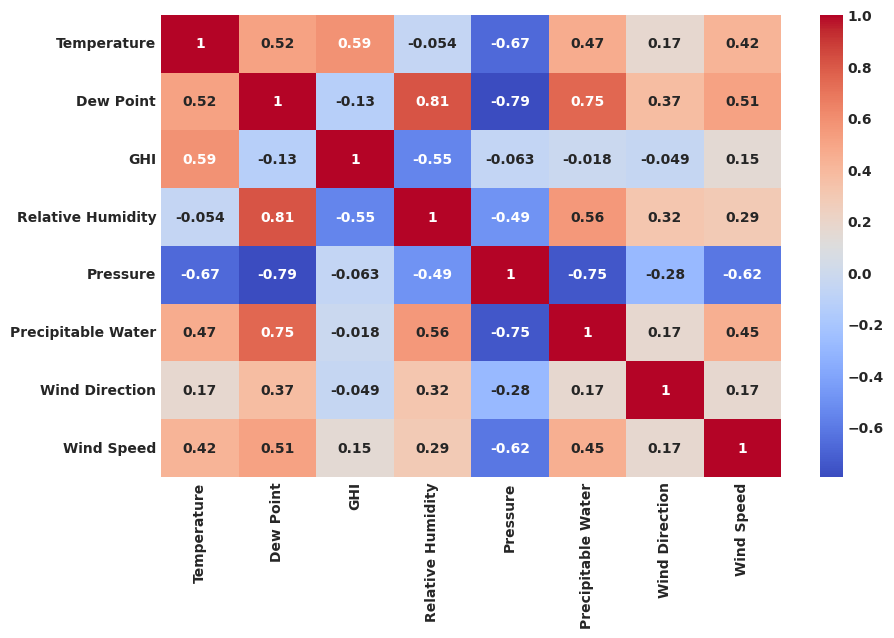

In [17]:
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'
plt.figure(figsize=(10,6))

sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

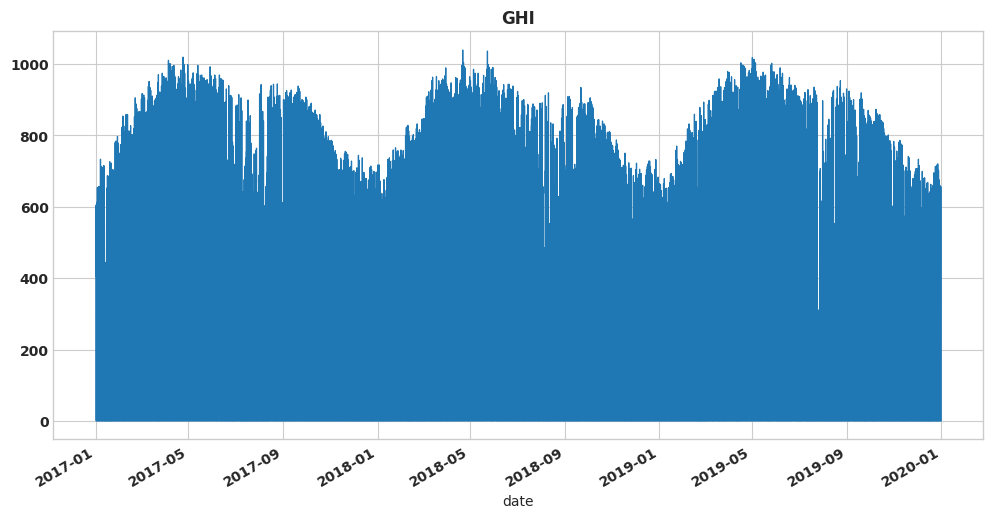

In [18]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
plt.title("GHI" ,  weight='bold')
df['GHI'].plot(linewidth=0.9 , use_index=True);

In [19]:
columns = df.columns.tolist()
columns[2], columns[-1] = columns[-1], columns[2]
df = df[columns]
df.head()

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction,GHI
date,,,,,,,,
2017-01-01 05:00:00,23.1,6.7,3.8,34.73,1017,1.2,74,406
2017-01-01 05:15:00,23.7,6.7,3.7,33.50,1017,1.2,74,443
2017-01-01 05:30:00,24.2,6.7,3.6,32.51,1017,1.2,75,478
2017-01-01 05:45:00,24.7,5.8,3.6,29.65,1017,1.2,76,497
2017-01-01 06:00:00,25.2,5.8,3.5,28.78,1017,1.2,77,525


In [20]:
X = df.drop('GHI' , axis=1)

In [21]:
X.head()

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction
date,,,,,,,
2017-01-01 05:00:00,23.1,6.7,3.8,34.73,1017,1.2,74
2017-01-01 05:15:00,23.7,6.7,3.7,33.50,1017,1.2,74
2017-01-01 05:30:00,24.2,6.7,3.6,32.51,1017,1.2,75
2017-01-01 05:45:00,24.7,5.8,3.6,29.65,1017,1.2,76
2017-01-01 06:00:00,25.2,5.8,3.5,28.78,1017,1.2,77


In [22]:
y = df['GHI']


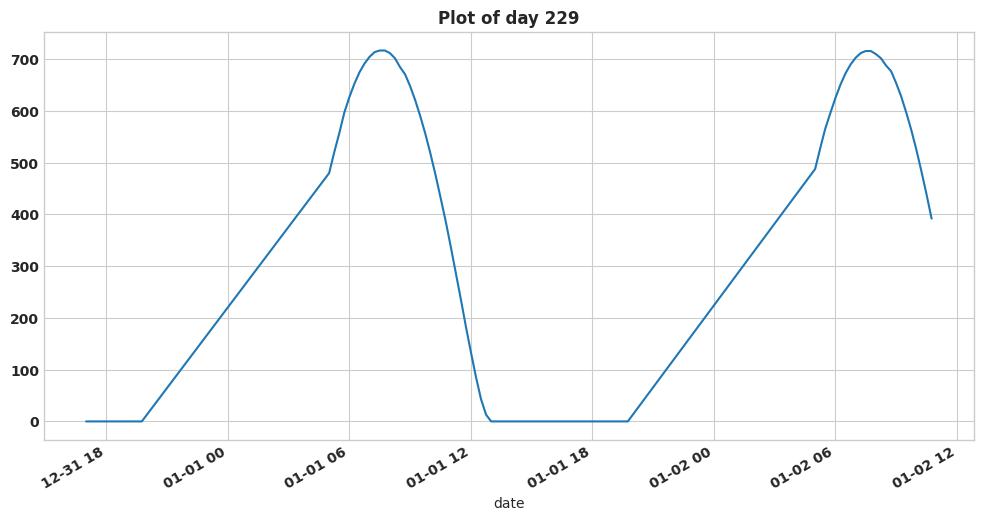

In [23]:
random_day = random.randint(1, 1095)
target_plot = df['GHI'][(random_day-1)*96:(random_day*96)]
plt.figure(figsize=(12,6))
target_plot.plot()
plt.title(str(f"Plot of day {random_day}") ,  weight='bold')
plt.show()

In [24]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head(10)                     # this normalizes the data in between range [0, 1]

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction
0,0.358491,0.443590,0.367347,0.281958,0.742857,0.116883,0.205556
1,0.381132,0.443590,0.357143,0.268427,0.742857,0.116883,0.205556
2,0.400000,0.443590,0.346939,0.257536,0.742857,0.116883,0.208333
3,0.418868,0.420513,0.346939,0.226073,0.742857,0.116883,0.211111
4,0.437736,0.420513,0.336735,0.216502,0.742857,0.116883,0.213889
5,0.449057,0.420513,0.316327,0.211001,0.742857,0.116883,0.216667
6,0.464151,0.420513,0.306122,0.203410,0.714286,0.116883,0.219444
7,0.475472,0.407692,0.295918,0.187569,0.714286,0.116883,0.222222
8,0.486792,0.407692,0.275510,0.182508,0.714286,0.116883,0.225000
9,0.494340,0.407692,0.265306,0.178878,0.685714,0.116883,0.230556


In [25]:
X.shape

(65700, 7)

In [26]:
per_day_readings = 4 * 24                  # readings in one hour x total number of hours in a day
days = 3                                   # this variable defines our window length
window_length = days * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                                # and then predict the next 15th minute reading

In [27]:
df = X.values                  # converting dataframe to numpy arrays
stride = 1
x = []
y = []
for i in tqdm(range(0, len(df) - window_length, stride)):
    x.append(df[i:window_length+i, : ])    # GHI included but its past values only
    y.append(df[window_length+i,-1])       # next GHI value as our target which is to be predicted by the model

  0%|          | 0/65412 [00:00<?, ?it/s]

In [28]:
x = np.array(x)                            # converting our features to numpy array
y = np.array(y)                            # converting our target to numpy array
print(x.shape)                             # printing our total feature data's shape
print(y.shape)                             # printing our target data's shape

(65412, 288, 7)
(65412,)


In [29]:
# splitting our dataset into two parts one will be training set and the other will be testing set
# Lets store last 5 days as our test set
testing_days = 10
per_day_readings = 4 * 24                  # readings in one hour x total number of hours in a day
days = 3                                   # this variable defines our window length
window_length = days * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                                # and then predict the next 15th minute reading


x_train = x[:-per_day_readings*testing_days]
y_train = y[:-per_day_readings*testing_days]
x_test  = x[len(y) - per_day_readings*testing_days:]
y_test  = y[len(y) - per_day_readings*testing_days:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(64452, 288, 7)
(64452,)
(960, 288, 7)
(960,)


In [30]:
set_epochs = 300

# **CNN_LSTM_MLP**
Hourly stepwise forecasting for solar irradiance using integrated hybrid models CNN-LSTM-MLP combined with error correction and VMD

In [31]:
# Define your CNN-LSTM-MLP model
from tensorflow.keras.layers import Convolution1D , Flatten , Conv1D , MaxPooling1D , LSTM , BatchNormalization , Dropout


cnn_lstm_mlp = Sequential()

# Convolutional layer
cnn_lstm_mlp.add(Conv1D(64, kernel_size=3, activation='relu',padding='same', input_shape=(288,7))) #4, 288
cnn_lstm_mlp.add(Conv1D(32, kernel_size=3, activation='relu'))
cnn_lstm_mlp.add(Dropout(0.3))
cnn_lstm_mlp.add(MaxPooling1D(pool_size=1))

# LSTM layer
cnn_lstm_mlp.add(LSTM(64, return_sequences=True))
cnn_lstm_mlp.add(LSTM(64))

# Flatten the output before MLP
cnn_lstm_mlp.add(Flatten())

# MLP layer
cnn_lstm_mlp.add(Dense(64, activation='relu'))
#cnn_lstm_mlp.add(Dense(64, activation='relu'))
cnn_lstm_mlp.add(Dense(32, activation='relu'))

#cnn_lstm_mlp.add(BatchNormalization())
cnn_lstm_mlp.add(Dense(1, activation='sigmoid'))  # Adjust output layer based on your task

# Compile the model
# Compile the model with the optimizer and learning rate
# Define the learning rate
learning_rate = 0.001

cnn_lstm_mlp.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Print the model summary
cnn_lstm_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 288, 64)           1408      
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 32)           6176      
                                                                 
 dropout (Dropout)           (None, 286, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 286, 32)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 286, 64)           24832     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                        

# **CNN_II model (Deep learning based long-term global solar irradiance and temperature forecasting using time series with multi-step multivariate output)**

In [32]:
from tensorflow.keras.layers import Convolution1D , Flatten

modelCNN = Sequential()

modelCNN.add(Convolution1D(50,
                 3,
                 activation='relu',
                 input_shape=(288, 7)))

modelCNN.add(Flatten())
modelCNN.add(Dense(50, activation='tanh'))  # Hidden layer
modelCNN.add(Dense(1, activation='linear'))  # Output layer

modelCNN.summary()


# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
modelCNN.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 286, 50)           1100      
                                                                 
 flatten_1 (Flatten)         (None, 14300)             0         
                                                                 
 dense_3 (Dense)             (None, 50)                715050    
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 716201 (2.73 MB)
Trainable params: 716201 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **MLP model (Short-term solar irradiance forecasting in streaming with deep learning)**

In [33]:
"""Creates Multi Layer Perceptron (MLP) model."""
import tensorflow as tf

def MLP(
    input_shape,
    output_size,
    loss,
    optimizer,
    hidden_layers=[32, 16, 8],
    dropout=0.0,
    activation="linear",
    out_activation="linear",
):
   
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)  # Convert the 2d input in a 1d array

    for hidden_units in hidden_layers:
        x = tf.keras.layers.Dense(hidden_units, activation=activation)(x)
        x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(output_size, activation=out_activation)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss='mae' , metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# Define the learning rate
learning_rate = 0.001

modelMLP = MLP(input_shape=(288, 7) ,output_size=1 , loss = 'mae' , optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate))


modelMLP.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 7)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 2016)              0         
                                                                 
 dense_5 (Dense)             (None, 32)                64544     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 136   

# **LSTM model (Solar Irradiance Forecasting Using Deep Learning Techniques)**

In [34]:
# LSTM Model
modelLSTM = tf.keras.Sequential([
    keras.layers.LSTM(64, input_shape=(288, 7), return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")
])
# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
modelLSTM.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

modelLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 288, 64)           18432     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51521 (201.25 KB)
Trainable params: 51521 (201.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **CNN-LSTM Sliding window approach with first-order differencing for very short-term solar irradiance forecasting using deep learning models**

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Reshape

input_shape = (288, 7)  

# Define CNN-LSTM model
model_cnn_lstm = Sequential()

# Input layer
model_cnn_lstm.add(Input(shape=input_shape))

# 1D CNN layer 1
model_cnn_lstm.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Dropout(0.25))

# 1D CNN layer 2
model_cnn_lstm.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Dropout(0.25))

# Flatten before passing to LSTM layers
model_cnn_lstm.add(tf.keras.layers.Flatten())

# Dense layers
model_cnn_lstm.add(Dense(256, activation='relu'))
model_cnn_lstm.add(Dense(128, activation='relu'))
model_cnn_lstm.add(Dropout(0.5))

# Reshape to add timestep dimension
model_cnn_lstm.add(Reshape((1, -1)))

# LSTM layer 1
model_cnn_lstm.add(LSTM(64, return_sequences=True))
model_cnn_lstm.add(Dropout(0.5))

# LSTM layer 2
model_cnn_lstm.add(LSTM(32))
model_cnn_lstm.add(Dropout(0.5))

# Dense layers
model_cnn_lstm.add(Dense(64, activation='relu'))
model_cnn_lstm.add(Dense(32, activation='relu'))

# Output layer
model_cnn_lstm.add(Dense(units=1, activation='sigmoid'))  # Adjust 'num_classes' based on your task

learning_rate = 0.001

model_cnn_lstm.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Print the model summary
model_cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 288, 64)           1408      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 144, 64)           0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 144, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 144, 128)          24704     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 72, 128)           0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 72, 128)          

# Proposed

In [36]:
# Define the CNN-LSTM model architecture
def create_cnn_lstm_knn(input_shape):
   
    # Create an CNN-LSTM model
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(64, return_sequences=True)) 
    model.add(LSTM(64)) 
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='sigmoid'))


    return model





In [37]:
cnn_lstm_knn = create_cnn_lstm_knn(input_shape=(288, 7)) 

In [38]:
# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
cnn_lstm_knn.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [39]:
cnn_lstm_knn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 288, 128)          2816      
                                                                 
 conv1d_6 (Conv1D)           (None, 288, 128)          49280     
                                                                 
 dropout_9 (Dropout)         (None, 288, 128)          0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 288, 128)          0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 288, 64)           49408     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                      

# **Fit Models**

In [40]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_cnn_lstm_mlp = cnn_lstm_mlp.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_cnn_lstm_mlp = t.time() - time1
print(f"Total time to train {epochs} of CNN_LSTM_MLP model is {time_cnn_lstm_mlp}")

Train...
Epoch 1/300


I0000 00:00:1707583528.180234      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 [==============================] - 14s 121ms/step - loss: 0.1145 - root_mean_squared_error: 0.1795 - val_loss: 0.0934 - val_root_mean_squared_error: 0.1489
Epoch 2/300
52/52 [==============================] - 5s 94ms/step - loss: 0.0579 - root_mean_squared_error: 0.1115 - val_loss: 0.0420 - val_root_mean_squared_error: 0.0925
Epoch 3/300
52/52 [==============================] - 5s 94ms/step - loss: 0.0423 - root_mean_squared_error: 0.0862 - val_loss: 0.0406 - val_root_mean_squared_error: 0.0750
Epoch 4/300
52/52 [==============================] - 5s 93ms/step - loss: 0.0346 - root_mean_squared_error: 0.0706 - val_loss: 0.0393 - val_root_mean_squared_error: 0.0662
Epoch 5/300
52/52 [==============================] - 5s 94ms/step - loss: 0.0306 - root_mean_squared_error: 0.0617 - val_loss: 0.0247 - val_root_mean_squared_error: 0.0538
Epoch 6/300
52/52 [==============================] - 5s 94ms/step - loss: 0.0274 - root_mean_squared_error: 0.0571 - val_loss: 0.0216 - val_root_mean_

In [41]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyCNN = modelCNN.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=8192)
timeCNN = t.time() - time1
print(f"Total time to train {epochs} of CNN model is {timeCNN}")

Train...
Epoch 1/300
7/7 [==============================] - 4s 233ms/step - loss: 4.9512 - root_mean_squared_error: 5.3265 - val_loss: 4.1718 - val_root_mean_squared_error: 4.1771
Epoch 2/300
7/7 [==============================] - 0s 71ms/step - loss: 1.8761 - root_mean_squared_error: 2.3316 - val_loss: 0.5763 - val_root_mean_squared_error: 0.6056
Epoch 3/300
7/7 [==============================] - 1s 76ms/step - loss: 0.4009 - root_mean_squared_error: 0.4728 - val_loss: 0.1769 - val_root_mean_squared_error: 0.2375
Epoch 4/300
7/7 [==============================] - 0s 70ms/step - loss: 0.1623 - root_mean_squared_error: 0.2229 - val_loss: 0.1697 - val_root_mean_squared_error: 0.2420
Epoch 5/300
7/7 [==============================] - 0s 70ms/step - loss: 0.1182 - root_mean_squared_error: 0.1851 - val_loss: 0.1332 - val_root_mean_squared_error: 0.1937
Epoch 6/300
7/7 [==============================] - 0s 71ms/step - loss: 0.1222 - root_mean_squared_error: 0.1774 - val_loss: 0.1301 - val_ro

In [42]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyLSTM = modelLSTM.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1, batch_size=8192)
timeLSTM = t.time() - time1
print(f"Total time to train {epochs} of LSTM model is {timeLSTM}")

Train...
Epoch 1/300
7/7 [==============================] - 7s 583ms/step - loss: 0.1508 - root_mean_squared_error: 0.1966 - val_loss: 0.1590 - val_root_mean_squared_error: 0.2343
Epoch 2/300
7/7 [==============================] - 3s 406ms/step - loss: 0.1106 - root_mean_squared_error: 0.1831 - val_loss: 0.1237 - val_root_mean_squared_error: 0.1992
Epoch 3/300
7/7 [==============================] - 3s 407ms/step - loss: 0.1046 - root_mean_squared_error: 0.1727 - val_loss: 0.1255 - val_root_mean_squared_error: 0.2082
Epoch 4/300
7/7 [==============================] - 3s 405ms/step - loss: 0.0998 - root_mean_squared_error: 0.1758 - val_loss: 0.1186 - val_root_mean_squared_error: 0.1977
Epoch 5/300
7/7 [==============================] - 3s 408ms/step - loss: 0.0953 - root_mean_squared_error: 0.1686 - val_loss: 0.1158 - val_root_mean_squared_error: 0.1952
Epoch 6/300
7/7 [==============================] - 3s 405ms/step - loss: 0.0903 - root_mean_squared_error: 0.1649 - val_loss: 0.1057 - v

In [43]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyMLP = modelMLP.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=8192)
timeMLP = t.time() - time1
print(f"Total time to train {epochs} of MLP model  is {timeMLP}")

Train...
Epoch 1/300
7/7 [==============================] - 2s 116ms/step - loss: 3.6066 - root_mean_squared_error: 4.3055 - val_loss: 0.7545 - val_root_mean_squared_error: 0.8293
Epoch 2/300
7/7 [==============================] - 0s 47ms/step - loss: 1.5062 - root_mean_squared_error: 1.7479 - val_loss: 1.3776 - val_root_mean_squared_error: 1.4140
Epoch 3/300
7/7 [==============================] - 0s 46ms/step - loss: 0.7662 - root_mean_squared_error: 0.8964 - val_loss: 0.8766 - val_root_mean_squared_error: 0.9216
Epoch 4/300
7/7 [==============================] - 0s 47ms/step - loss: 0.5057 - root_mean_squared_error: 0.5982 - val_loss: 0.3134 - val_root_mean_squared_error: 0.3750
Epoch 5/300
7/7 [==============================] - 0s 45ms/step - loss: 0.2995 - root_mean_squared_error: 0.3614 - val_loss: 0.3439 - val_root_mean_squared_error: 0.3957
Epoch 6/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2369 - root_mean_squared_error: 0.2917 - val_loss: 0.2021 - val_ro

In [44]:
time1 = t.time()
print('Train...')
epochs = set_epochs
history_cnn_lstm = model_cnn_lstm.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=8192)
time_cnn_lstm = t.time() - time1
print(f"Total time to train {epochs} of CNN LSTM model  is {time_cnn_lstm}")

Train...
Epoch 1/300
7/7 [==============================] - 11s 587ms/step - loss: 0.1862 - root_mean_squared_error: 0.2116 - val_loss: 0.1388 - val_root_mean_squared_error: 0.2068
Epoch 2/300
7/7 [==============================] - 1s 174ms/step - loss: 0.1296 - root_mean_squared_error: 0.1913 - val_loss: 0.1664 - val_root_mean_squared_error: 0.2522
Epoch 3/300
7/7 [==============================] - 1s 178ms/step - loss: 0.1244 - root_mean_squared_error: 0.2019 - val_loss: 0.1362 - val_root_mean_squared_error: 0.2265
Epoch 4/300
7/7 [==============================] - 1s 173ms/step - loss: 0.1183 - root_mean_squared_error: 0.1902 - val_loss: 0.1319 - val_root_mean_squared_error: 0.2139
Epoch 5/300
7/7 [==============================] - 1s 178ms/step - loss: 0.1164 - root_mean_squared_error: 0.1889 - val_loss: 0.1321 - val_root_mean_squared_error: 0.2190
Epoch 6/300
7/7 [==============================] - 1s 173ms/step - loss: 0.1153 - root_mean_squared_error: 0.1926 - val_loss: 0.1320 - 

In [45]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_cnn_lstm_knn = cnn_lstm_knn.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_cnn_lstm_knn = t.time() - time1
print(f"Total time to train {epochs} of CNN_LSTM_MLP_KNN model is {time_cnn_lstm_knn}")

Train...
Epoch 1/300
52/52 [==============================] - 13s 157ms/step - loss: 0.1153 - root_mean_squared_error: 0.1718 - val_loss: 0.0724 - val_root_mean_squared_error: 0.1303
Epoch 2/300
52/52 [==============================] - 6s 125ms/step - loss: 0.0471 - root_mean_squared_error: 0.0961 - val_loss: 0.0365 - val_root_mean_squared_error: 0.0751
Epoch 3/300
52/52 [==============================] - 6s 124ms/step - loss: 0.0312 - root_mean_squared_error: 0.0677 - val_loss: 0.0232 - val_root_mean_squared_error: 0.0578
Epoch 4/300
52/52 [==============================] - 6s 124ms/step - loss: 0.0266 - root_mean_squared_error: 0.0579 - val_loss: 0.0230 - val_root_mean_squared_error: 0.0503
Epoch 5/300
52/52 [==============================] - 6s 124ms/step - loss: 0.0241 - root_mean_squared_error: 0.0526 - val_loss: 0.0170 - val_root_mean_squared_error: 0.0448
Epoch 6/300
52/52 [==============================] - 6s 124ms/step - loss: 0.0219 - root_mean_squared_error: 0.0495 - val_los

In [46]:
# Get the output from the Flatten layer of the CNN-LSTM model
flatten_output_train = cnn_lstm_knn.predict(x_train)
flatten_output_test = cnn_lstm_knn.predict(x_test)
# try not flatten test

30/30 [==============================] - 0s 11ms/step


In [47]:
#Import Libraries
from sklearn.neighbors import KNeighborsRegressor

#Applying KNeighborsRegressor Model 
proposed = KNeighborsRegressor(n_neighbors = 20, weights='uniform', 
                                               algorithm = 'auto')    
proposed.fit(flatten_output_train, y_train)



KNeighborsRegressor(n_neighbors=20)

In [48]:
# Extract the history of loss and metric result from the history object

#CNN-LSTM-MlP
loss_history_cnn_lstm_mlp = history_cnn_lstm_mlp.history['loss']
r2_history_cnn_lstm_mlp = history_cnn_lstm_mlp.history['root_mean_squared_error']

#CNN
loss_history_cnn = historyCNN.history['loss']
r2_history_cnn = historyCNN.history['root_mean_squared_error']

#MLP
loss_history_mlp = historyMLP.history['loss']
r2_history_mlp = historyMLP.history['root_mean_squared_error']

#LSTM
loss_history_lstm = historyLSTM.history['loss']
r2_history_lstm = historyLSTM.history['root_mean_squared_error']

#CNN LSTM
loss_history_cnn_lstm = history_cnn_lstm.history['loss']
r2_history_cnn_lstm = history_cnn_lstm.history['root_mean_squared_error']

#CNN-LSTM-MLP-KNN
loss_history_proposed = history_cnn_lstm_knn.history['loss']
r2_history_proposed = history_cnn_lstm_knn.history['root_mean_squared_error']



# CNN_LSTM_MLP loss and Metric Plot

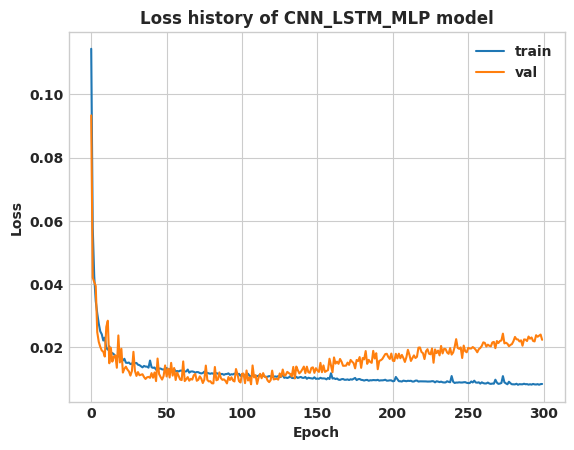

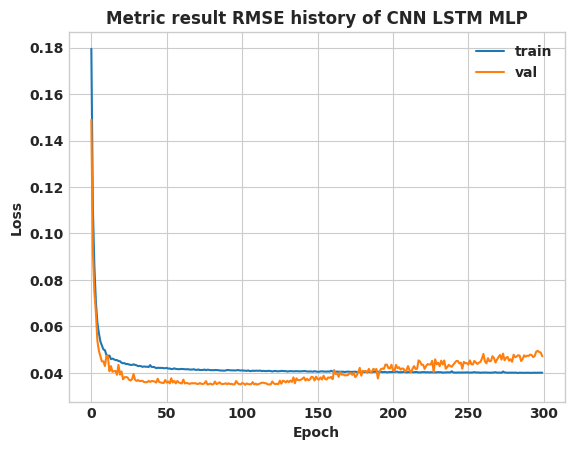

In [49]:
# Plot the history of loss and r2 of CNN LSTM MLP
plt.plot(history_cnn_lstm_mlp.history['loss'] , label='train')
plt.plot(history_cnn_lstm_mlp.history['val_loss'], label='val')
plt.title('Loss history of CNN_LSTM_MLP model' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()


plt.plot(history_cnn_lstm_mlp.history['root_mean_squared_error'] , label='train')
plt.plot(history_cnn_lstm_mlp.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of CNN LSTM MLP' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()

# **CNN loss and Metric Plot**

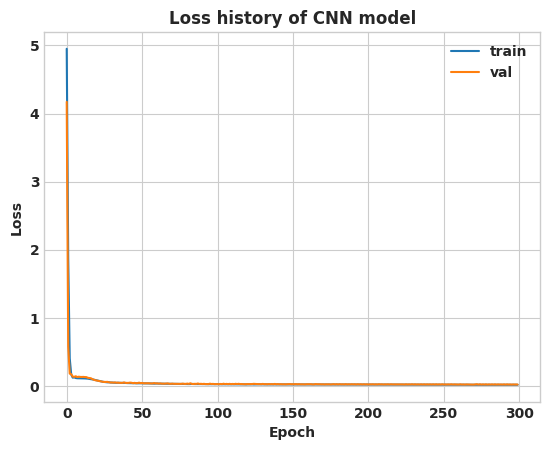

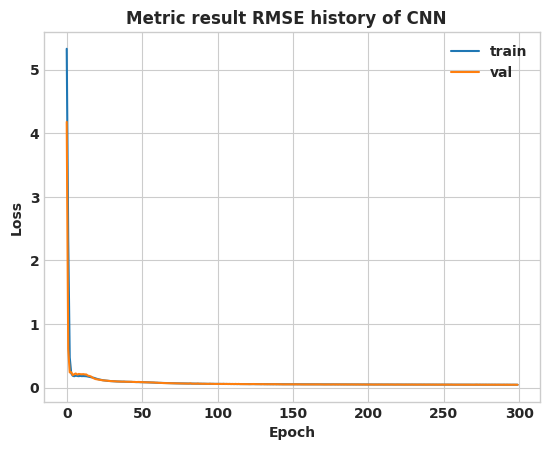

In [50]:
# Plot the history of loss and r2 of CNN LSTM MLP
plt.plot(loss_history_cnn , label='train')
plt.plot(historyCNN.history['val_loss'], label='val')
plt.title('Loss history of CNN model' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()


plt.plot(r2_history_cnn , label='train')
plt.plot(historyCNN.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of CNN  ' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()

# **MLP loss and Metric Plot**

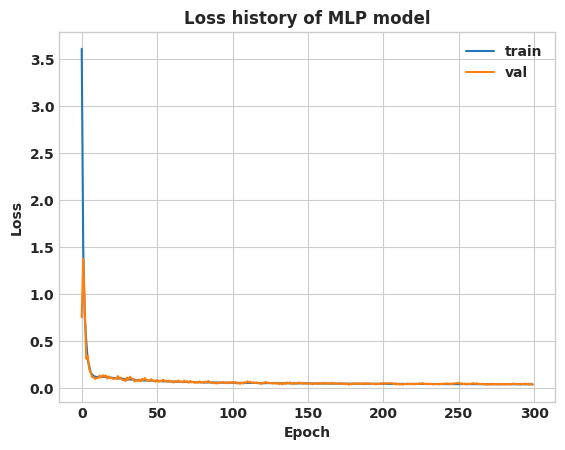

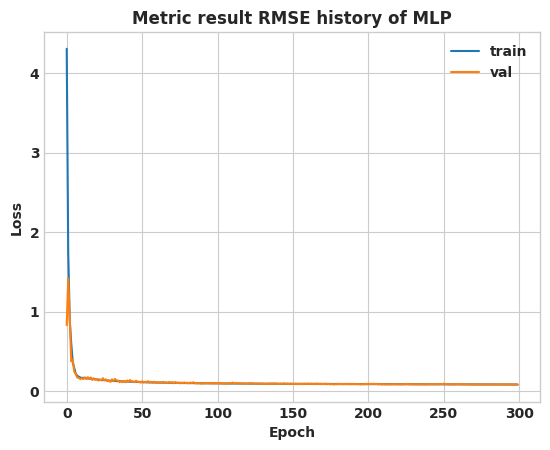

In [51]:
# Plot the history of loss and r2 of MLP
plt.plot(loss_history_mlp , label='train')
plt.plot(historyMLP.history['val_loss'], label='val')
plt.title('Loss history of MLP model' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()


plt.plot(r2_history_mlp , label='train')
plt.plot(historyMLP.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of MLP' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()

# **LSTM loss and Metric Plot**

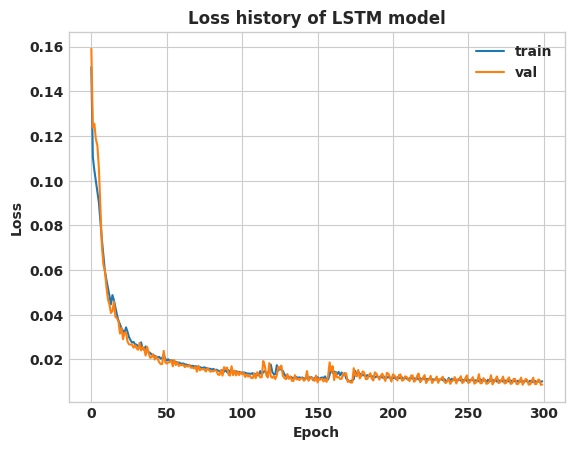

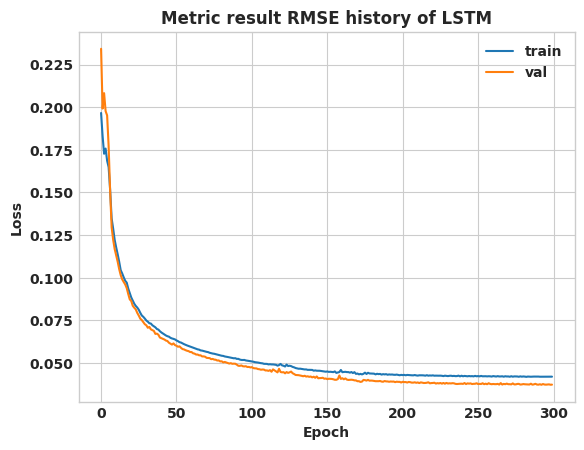

In [52]:
# Plot the history of loss and r2 of LSTM
plt.plot(loss_history_lstm , label='train')
plt.plot(historyLSTM.history['val_loss'], label='val')
plt.title('Loss history of LSTM model' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()


plt.plot(r2_history_lstm , label='train')
plt.plot(historyLSTM.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of LSTM' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()

# **CNN-LSTM loss and Metric Plot**

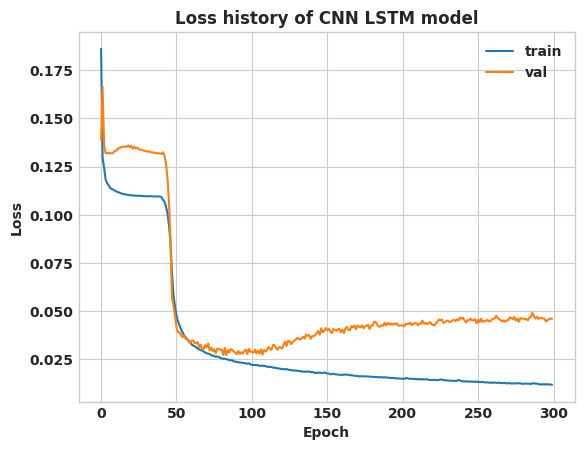

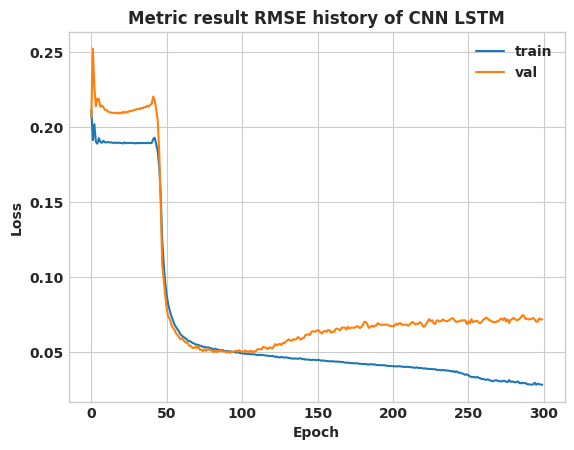

In [53]:
# Plot the history of loss and r2 of LSTM
plt.plot(loss_history_cnn_lstm , label='train')
plt.plot(history_cnn_lstm.history['val_loss'], label='val')
plt.title('Loss history of CNN LSTM model' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()


plt.plot(r2_history_cnn_lstm , label='train')
plt.plot(history_cnn_lstm.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of CNN LSTM' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()

# Proposed loss and Metric Plot

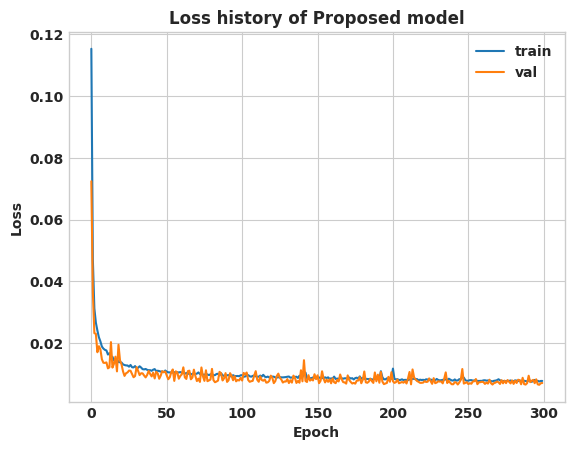

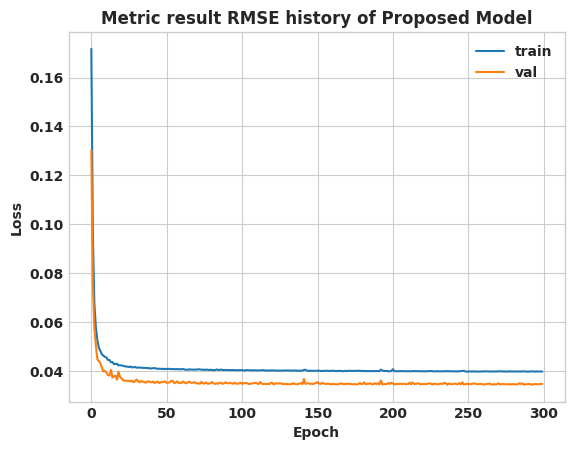

In [54]:
# Plot the history of loss and r2 of Proposed
plt.plot(loss_history_proposed , label='train')
plt.plot(history_cnn_lstm_knn.history['val_loss'], label='val')
plt.title('Loss history of Proposed model' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()


plt.plot(r2_history_proposed , label='train')
plt.plot(history_cnn_lstm_knn.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of Proposed Model' , weight='bold')
plt.xlabel('Epoch' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.legend()
plt.show()

In [55]:
# CNN LSTM MLP
t1 = t.time()
cnn_lstm_mlp_predictions = cnn_lstm_mlp.predict(x_test)
infer_cnn_lstm_mlp = t.time() - t1

# CNN prediction
t1 = t.time()
predictionCNN = modelCNN.predict(x_test)
inferCNN = t.time() - t1

# MLP prediction
t1 = t.time()
predictionMLP = modelMLP.predict(x_test)
inferMLP = t.time() - t1

# LSTM prediction
t1 = t.time()
predictionLSTM = modelLSTM.predict(x_test)
inferLSTM = t.time() - t1

# CNN LSTM prediction
t1 = t.time()
prediction_cnn_lstm = model_cnn_lstm.predict(x_test)
infer_cnn_lstm = t.time() - t1

# Proposed
t1 = t.time()
proposed_predictions = proposed.predict(flatten_output_test)
infer_proposed = t.time() - t1

30/30 [==============================] - 1s 3ms/step


In [56]:
#Calculating Mean Absolute Error
#Import Libraries
from sklearn.metrics import mean_absolute_error 

mae_CNNLSTMMLP = mean_absolute_error(y_test, cnn_lstm_mlp_predictions) # it can be raw_values
print('Mean Absolute Error Value CNN-LSTM-MLP : ',  round(mae_CNNLSTMMLP, 6))

MAE_CNN = mean_absolute_error(y_test, predictionCNN.reshape(predictionCNN.shape[0])  )
print("Mean Absolute Error (CNN):", round(MAE_CNN, 6))

MAE_MLP = mean_absolute_error(y_test, predictionMLP.reshape(predictionMLP.shape[0])  )
print("Mean Absolute Error (MLP):", round(MAE_MLP, 6))

MAE_LSTM = mean_absolute_error(y_test, predictionLSTM.reshape(predictionLSTM.shape[0]))
print("Mean Absolute Error (LSTM):", round(MAE_LSTM, 6))

MAE_cnn_lstm = mean_absolute_error(y_test, prediction_cnn_lstm.reshape(prediction_cnn_lstm.shape[0]))
print("Mean Absolute Error (CNN LSTM):", round(MAE_cnn_lstm, 6))

mae_proposed = mean_absolute_error(y_test, proposed_predictions.reshape(proposed_predictions.shape[0])  )
print("Mean Absolute Error Proposed Model:", round(mae_proposed, 6))

Mean Absolute Error Value CNN-LSTM-MLP :  0.067404
Mean Absolute Error (CNN): 0.026423
Mean Absolute Error (MLP): 0.063332
Mean Absolute Error (LSTM): 0.015545
Mean Absolute Error (CNN LSTM): 0.113468
Mean Absolute Error Proposed Model: 0.013928


In [57]:
#Calculating Mean Absolute Error
#Import Libraries
from sklearn.metrics import mean_absolute_error 

mse_CNNLSTMMLP = mean_squared_error(y_test, cnn_lstm_mlp_predictions) # it can be raw_values
print('Mean Squared Error Value CNN-LSTM-MLP : ',  round(mse_CNNLSTMMLP, 6))

MSE_CNN = mean_squared_error(y_test, predictionCNN.reshape(predictionCNN.shape[0])  )
print("Mean Squared Error (CNN):", round(MSE_CNN, 6))

MSE_MLP = mean_squared_error(y_test, predictionMLP.reshape(predictionMLP.shape[0])  )
print("Mean Squared Error (MLP):", round(MSE_MLP, 6))

MSE_LSTM = mean_squared_error(y_test, predictionLSTM.reshape(predictionLSTM.shape[0]))
print("Mean Squared Error (LSTM):", round(MSE_LSTM, 6))

MSE_cnn_lstm = mean_squared_error(y_test, prediction_cnn_lstm.reshape(prediction_cnn_lstm.shape[0]))
print("Mean Squared Error (CNN LSTM):", round(MAE_cnn_lstm, 6))

mse_proposed = mean_squared_error(y_test, proposed_predictions.reshape(proposed_predictions.shape[0])  )
print("Mean Squared Error Proposed Model:", round(mse_proposed, 6))


Mean Squared Error Value CNN-LSTM-MLP :  0.005701
Mean Squared Error (CNN): 0.003036
Mean Squared Error (MLP): 0.0162
Mean Squared Error (LSTM): 0.002358
Mean Squared Error (CNN LSTM): 0.113468
Mean Squared Error Proposed Model: 0.001398


In [58]:
print("Root Mean Squared Error (CNN-LSTM-MLP):", round(math.sqrt(mse_CNNLSTMMLP), 6))

print("Root Mean Squared Error (CNN):", round(math.sqrt(MSE_CNN), 6))

print("Root Mean Squared Error (MLP):", round(math.sqrt(MSE_MLP), 6))

print("Root Mean Squared Error (LSTM):", round(math.sqrt(MSE_LSTM), 6))

print("Root Mean Squared Error (CNN LSTM):", round(math.sqrt(MSE_cnn_lstm), 6))

print("Root Mean Squared Error Proposed Model:", round(math.sqrt(mse_proposed), 6))


Root Mean Squared Error (CNN-LSTM-MLP): 0.075502
Root Mean Squared Error (CNN): 0.055102
Root Mean Squared Error (MLP): 0.127278
Root Mean Squared Error (LSTM): 0.048556
Root Mean Squared Error (CNN LSTM): 0.127971
Root Mean Squared Error Proposed Model: 0.037386


In [59]:
R2_acc_cnn_lstm_mlp = r2_score(y_test, cnn_lstm_mlp_predictions)
r2_cnn = r2_score(y_test, predictionCNN.reshape(predictionCNN.shape[0]))
r2_mlp = r2_score(y_test, predictionMLP.reshape(predictionMLP.shape[0]))
r2_lstm = r2_score(y_test, predictionLSTM.reshape(predictionLSTM.shape[0]))
r2_cnn_lstm = r2_score(y_test, prediction_cnn_lstm.reshape(prediction_cnn_lstm.shape[0]))
r2acc_proposed = r2_score(y_test, proposed_predictions.reshape(proposed_predictions.shape[0]))


In [60]:
print("R2 accuracy of CNN-LSTM-MLP model is :",round(R2_acc_cnn_lstm_mlp, 6)   )

print("R2 accuracy of CNN model is :",round(r2_cnn, 6)  )

print("R2 accuracy of MLP model is :",round(r2_mlp , 6)   )

print("R2 accuracy of LSTM model is :",round(r2_lstm, 6))

print("R2 accuracy of CNN LSTM model is :",round(r2_cnn_lstm, 6))

print("R2 accuracy of Proposed model is :",round(r2acc_proposed, 6)   )

R2 accuracy of CNN-LSTM-MLP model is : 0.926316
R2 accuracy of CNN model is : 0.960754
R2 accuracy of MLP model is : 0.790603
R2 accuracy of LSTM model is : 0.969525
R2 accuracy of CNN LSTM model is : 0.788318
R2 accuracy of Proposed model is : 0.981933


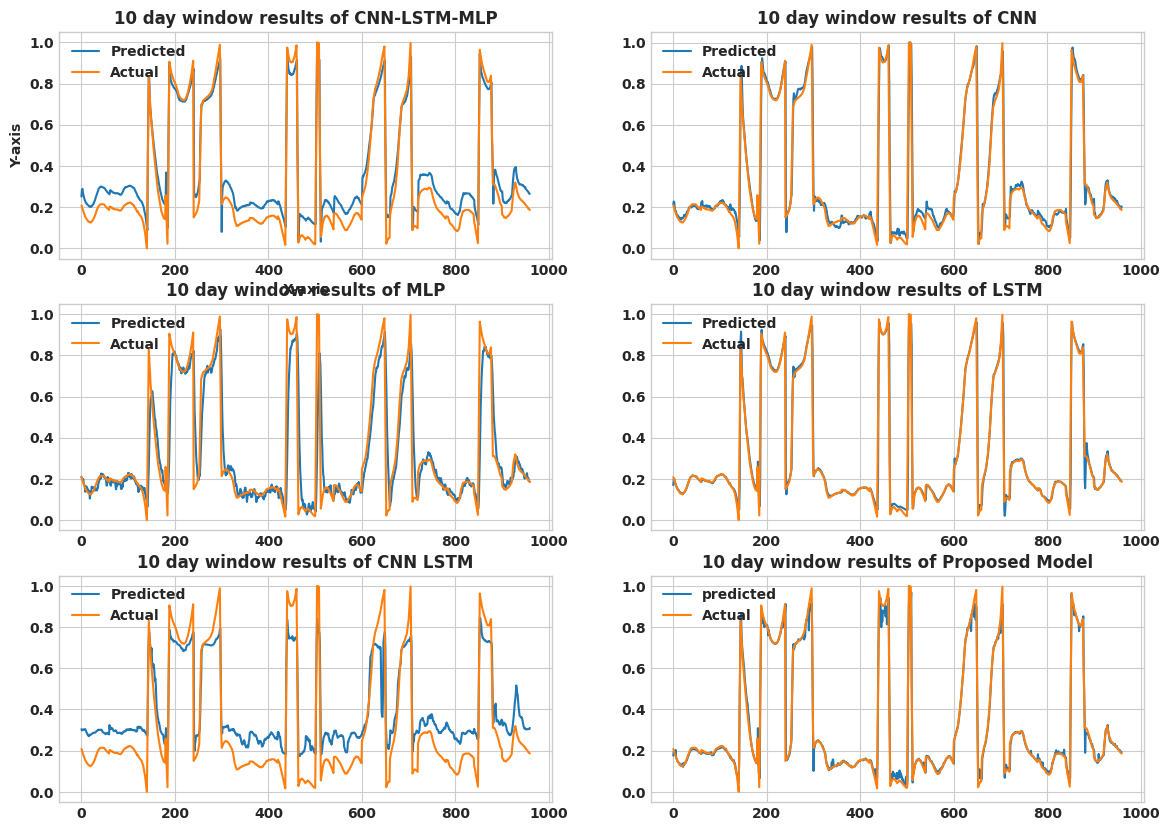

In [61]:
# Making the figure size bigger
plt.figure(figsize=(14, 10))
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'

# Cnn-LStm-MLP's prediction plot
plt.subplot(3,2,1)

plt.plot(cnn_lstm_mlp_predictions)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of CNN-LSTM-MLP' , weight='bold')
plt.xlabel('X-axis', weight='bold')
plt.ylabel('Y-axis', weight='bold')
plt.legend(['Predicted', 'Actual'] , loc ="upper left")



# RNN's prediction plot
plt.subplot(3,2,2)
plt.plot(predictionCNN)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of CNN' ,  weight='bold')
plt.legend(['Predicted', 'Actual'] , loc ="upper left")

# GRU's prediction plot
plt.subplot(3,2,3)
plt.plot(predictionMLP)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of MLP' ,  weight='bold')
plt.legend(['Predicted', 'Actual'] , loc ="upper left")

# LSTM's prediction plot
plt.subplot(3,2,4)
plt.plot(predictionLSTM)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of LSTM' ,  weight='bold')
plt.legend(['Predicted', 'Actual'] , loc ="upper left")

# CNN LSTM's prediction plot
plt.subplot(3,2,5)
plt.plot(prediction_cnn_lstm)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of CNN LSTM' ,  weight='bold')
plt.legend(['Predicted', 'Actual'] , loc ="upper left")

# Proposed prediction plot
plt.subplot(3,2,6)
plt.plot(proposed_predictions)
plt.plot(y_test)
plt.title(f'{testing_days} day window results of Proposed Model'  , weight='bold')
plt.legend(['predicted', 'Actual'] , loc ="upper left")



plt.savefig('predicted graphs.png')


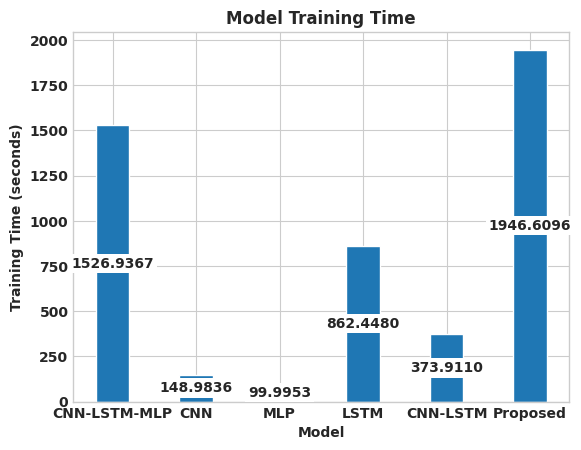

In [62]:
import numpy as np

models = ['CNN-LSTM-MLP', 'CNN', 'MLP', 'LSTM', 'CNN-LSTM', 'Proposed']
timeTrain = [time_cnn_lstm_mlp, timeCNN, timeMLP, timeLSTM, time_cnn_lstm, time_cnn_lstm_knn]

bar_width = 0.4  # Adjust the width as per your preference

plt.bar(np.arange(len(models)), timeTrain, width=bar_width)
plt.xlabel('Model', weight='bold')
plt.ylabel('Training Time (seconds)', weight='bold')
plt.title('Model Training Time', weight='bold')
plt.xticks(np.arange(len(models)), models)  # Set the x-axis tick labels to the model names

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, timeTrain[i]/2, "{:.4f}".format(timeTrain[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

plt.savefig('/kaggle/working/trainingImg.png')
plt.show()

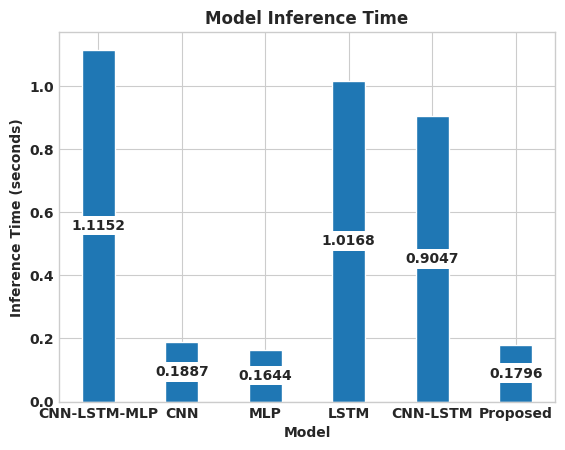

In [63]:
timeInfer = [infer_cnn_lstm_mlp , inferCNN, inferMLP, inferLSTM ,infer_cnn_lstm, infer_proposed]

bar_width = 0.4  # Adjust the width as per your preference

plt.bar(np.arange(len(models)), timeInfer, width=bar_width)
plt.xlabel('Model' , weight='bold')
plt.ylabel('Inference Time (seconds)' , weight='bold')
plt.title('Model Inference Time' , weight='bold')
plt.xticks(np.arange(len(models)), models)  # Set the x-axis tick labels to the model names

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, timeInfer[i]/2, "{:.4f}".format(timeInfer[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

    
    
plt.savefig('/kaggle/working/InferingImg.png')
plt.show()

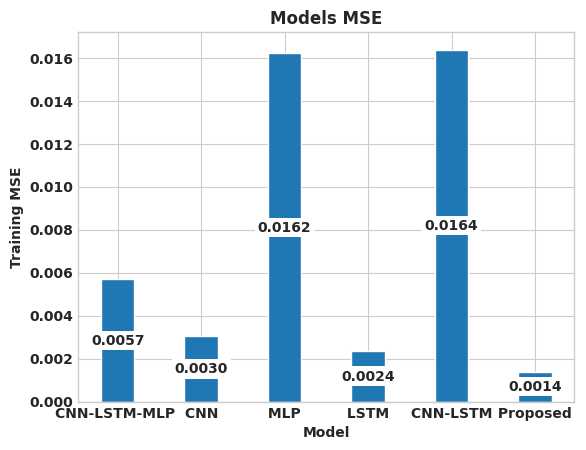

In [64]:
models = ['CNN-LSTM-MLP ',' CNN ', ' MLP ', ' LSTM ',' CNN-LSTM ', ' Proposed ']
MSE = [mse_CNNLSTMMLP,MSE_CNN, MSE_MLP, MSE_LSTM, MSE_cnn_lstm , mse_proposed]
    
bar_width = 0.4  # Adjust the width as per your preference

plt.bar(np.arange(len(models)), MSE, width=bar_width)
plt.xlabel('Model' , weight='bold')
plt.ylabel('Training MSE' , weight='bold')
plt.title('Models MSE' , weight='bold')
plt.xticks(np.arange(len(models)), models)  # Set the x-axis tick labels to the model names

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, MSE[i]/2, "{:.4f}".format(MSE[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin
    
plt.savefig('/kaggle/working/mse.png')
plt.show()

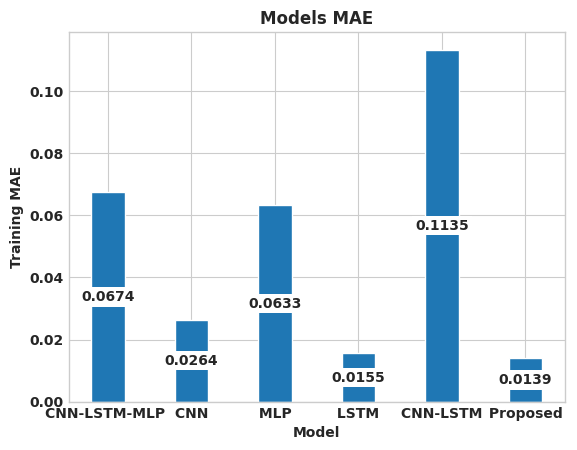

In [65]:
models = ['CNN-LSTM-MLP ',' CNN ', ' MLP ', ' LSTM ',' CNN-LSTM ', ' Proposed ']
MAE = [mae_CNNLSTMMLP,MAE_CNN, MAE_MLP, MAE_LSTM, MAE_cnn_lstm , mae_proposed]

bar_width = 0.4  # Adjust the width as per your preference

plt.bar(np.arange(len(models)), MAE, width=bar_width)
plt.xlabel('Model' , weight='bold')
plt.ylabel('Training MAE' , weight='bold')
plt.title('Models MAE' , weight='bold')
plt.xticks(np.arange(len(models)), models)  # Set the x-axis tick labels to the model names

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, MAE[i]/2, "{:.4f}".format(MAE[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

plt.savefig('/kaggle/working/mae.png')
plt.show()

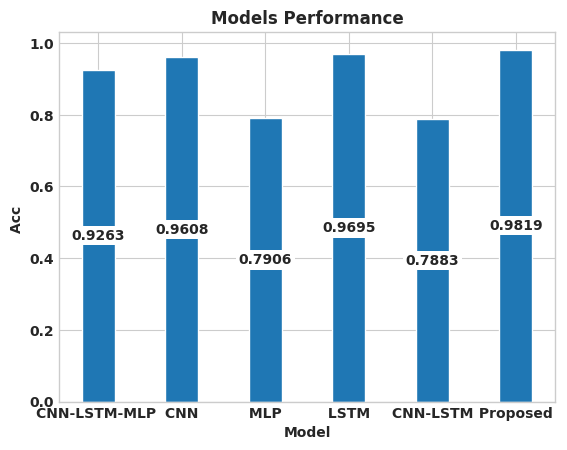

In [66]:
models = ['CNN-LSTM-MLP ',' CNN ', ' MLP ', ' LSTM ',' CNN-LSTM ', ' Proposed ']
R2 = [R2_acc_cnn_lstm_mlp , r2_cnn, r2_mlp, r2_lstm ,r2_cnn_lstm, r2acc_proposed]


bar_width = 0.4  # Adjust the width as per your preference

plt.bar(np.arange(len(models)), R2, width=bar_width)
plt.xlabel('Model' , weight='bold')
plt.ylabel('Acc ' , weight='bold')
plt.title('Models Performance',  weight='bold')
plt.xticks(np.arange(len(models)), models)  # Set the x-axis tick labels to the model names

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, R2[i]/2, "{:.4f}".format(R2[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

plt.savefig('/kaggle/working/r2.png')
plt.show()

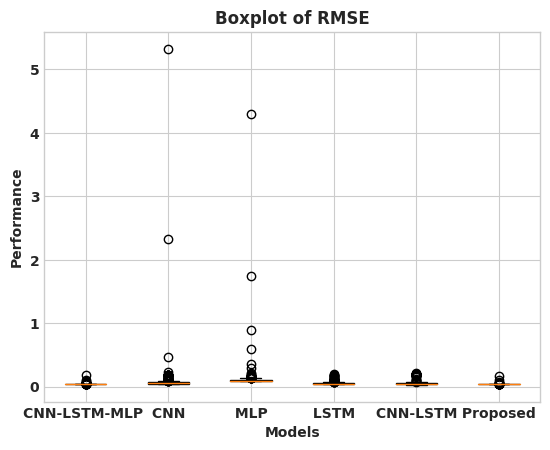

In [67]:
import matplotlib.pyplot as plt
import numpy as np


# Combine the data into a list
all_data = [r2_history_cnn_lstm_mlp, r2_history_cnn, r2_history_mlp, r2_history_lstm,r2_history_cnn_lstm, r2_history_proposed]

# Define colors for each box
box_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink' , 'blue']

# Create a boxplot with filled colors
boxplot = plt.boxplot(all_data, labels=['CNN-LSTM-MLP ',' CNN ', ' MLP ', ' LSTM ',' CNN-LSTM ', ' Proposed '], patch_artist=True)

# Assign colors to the boxes
for box, color in zip(boxplot['boxes'], box_colors):
    box.set_facecolor(color)

# Add labels and title
plt.xlabel('Models' , weight='bold')
plt.ylabel('Performance' , weight='bold')
plt.title('Boxplot of RMSE' ,  weight='bold')

# Show the plot
plt.show()

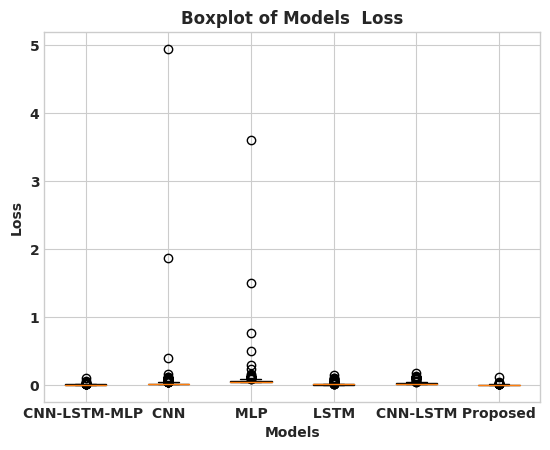

In [68]:
import matplotlib.pyplot as plt
import numpy as np


# Combine the data into a list
all_data = [loss_history_cnn_lstm_mlp, loss_history_cnn, loss_history_mlp, loss_history_lstm,loss_history_cnn_lstm, loss_history_proposed]

# Define colors for each box
box_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink' , 'blue']

# Create a boxplot with filled colors
boxplot = plt.boxplot(all_data, labels=['CNN-LSTM-MLP ',' CNN ', ' MLP ', ' LSTM ',' CNN-LSTM ', ' Proposed '], patch_artist=True)

# Assign colors to the boxes
for box, color in zip(boxplot['boxes'], box_colors):
    box.set_facecolor(color)

# Add labels and title
plt.xlabel('Models' , weight='bold')
plt.ylabel('Loss' , weight='bold')
plt.title('Boxplot of Models  Loss' ,  weight='bold')

# Show the plot
plt.show()